<a href="https://colab.research.google.com/github/SeungHan0816/WM-811k_Wafermap_Practice/blob/main/WM_811k_Wafermap_DL_MNV3_L_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MobileNetV3-Large 알고리즘 사용

# 0️⃣ 0단계. 패키지 설치 및 환경 변수 설정
!pip install kagglehub --quiet

import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
print("환경 설정 완료")


환경 설정 완료


In [ ]:
# 1️⃣ 1단계. 라이브러리 임포트 및 디바이스 설정
import kagglehub
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# 여기만 mobilenet_v3_large 로 변경
from torchvision.models import mobilenet_v3_large
from skimage.transform import resize
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# 2️⃣ 2단계. 데이터 로딩 및 전처리
path = kagglehub.dataset_download('qingyi/wm811k-wafer-map')
df = pd.read_pickle(os.path.join(path, "LSWMD.pkl"))

def safe_extract_failure_type(x):
    while isinstance(x, (list, np.ndarray)):
        if isinstance(x, np.ndarray) and x.shape == ():
            x = x.item(); continue
        if len(x) == 0:
            return 'none'
        x = x[0]
    return x if isinstance(x, str) else str(x)

df['failureType'] = df['failureType'].apply(safe_extract_failure_type)

failure_map = {
    'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3,
    'Loc':4, 'Random':5, 'Scratch':6, 'Near-full':7,
    'none':8
}
df['label'] = df['failureType'].map(failure_map)
df = df[df['label'] != 8].reset_index(drop=True)

for col in ['waferIndex','lotName','trianTestLabel']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

print("데이터 로딩 및 전처리 완료")


100%|██████████| 149M/149M [00:04<00:00, 37.0MB/s]

Extracting files...


데이터 로딩 및 전처리 완료


In [ ]:
# 3️⃣ 3단계. Custom Dataset 클래스 정의 (128×128 리사이즈 + 간단 증강)
class WaferDataset(Dataset):
    def __init__(self, df):
        self.maps   = df['waferMap'].values
        self.labels = df['label'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.maps[idx].astype(np.float32)
        img = resize(img, (128, 128), order=0, preserve_range=True).astype(np.float32)
        # ─── 과적합 방지용 증강 ───
        if np.random.rand() < 0.5:
            img = np.flip(img, axis=1)  # 수평 뒤집기
        if np.random.rand() < 0.5:
            img = np.flip(img, axis=0)  # 수직 뒤집기
        # ────────────────────────
        img = np.repeat(img[None], 3, axis=0) / 2.0
        return torch.tensor(img), torch.tensor(self.labels[idx], dtype=torch.long)

print("Custom Dataset 클래스 정의 완료")


Custom Dataset 클래스 정의 완료


In [ ]:
# 4️⃣ 4단계. 데이터 분할 및 통계 출력, DataLoader 구성
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print(f"🔹 전체 샘플 수: {len(df)}개")
print("📊 전체 클래스별 분포:")
for l, c in df['label'].value_counts().sort_index().items():
    print(f"  클래스 {l}: {c}개 ({c/len(df)*100:.2f}%)")

print(f"\n🟢 학습 데이터 수: {len(train_df)}개")
print("📘 학습 데이터 클래스 분포:")
for l, c in train_df['label'].value_counts().sort_index().items():
    print(f"  클래스 {l}: {c}개 ({c/len(train_df)*100:.2f}%)")

print(f"\n🔵 테스트 데이터 수: {len(test_df)}개")
print("📙 테스트 데이터 클래스 분포:")
for l, c in test_df['label'].value_counts().sort_index().items():
    print(f"  클래스 {l}: {c}개 ({c/len(test_df)*100:.2f}%)")

label_counts   = np.bincount(train_df['label'])
class_weights  = 1.0 / label_counts
sample_weights = class_weights[train_df['label'].values]
sampler        = WeightedRandomSampler(
    sample_weights, num_samples=len(sample_weights), replacement=True
)

train_loader = DataLoader(
    WaferDataset(train_df), batch_size=6, sampler=sampler, num_workers=2
)
test_loader  = DataLoader(
    WaferDataset(test_df), batch_size=6, shuffle=False, num_workers=2
)

print("데이터 분할 및 DataLoader 구성 완료")


🔹 전체 샘플 수: 25519개
📊 전체 클래스별 분포:
  클래스 0: 4294개 (16.83%)
  클래스 1: 555개 (2.17%)
  클래스 2: 5189개 (20.33%)
  클래스 3: 9680개 (37.93%)
  클래스 4: 3593개 (14.08%)
  클래스 5: 866개 (3.39%)
  클래스 6: 1193개 (4.67%)
  클래스 7: 149개 (0.58%)

🟢 학습 데이터 수: 20415개
📘 학습 데이터 클래스 분포:
  클래스 0: 3435개 (16.83%)
  클래스 1: 444개 (2.17%)
  클래스 2: 4151개 (20.33%)
  클래스 3: 7744개 (37.93%)
  클래스 4: 2874개 (14.08%)
  클래스 5: 693개 (3.39%)
  클래스 6: 955개 (4.68%)
  클래스 7: 119개 (0.58%)

🔵 테스트 데이터 수: 5104개
📙 테스트 데이터 클래스 분포:
  클래스 0: 859개 (16.83%)
  클래스 1: 111개 (2.17%)
  클래스 2: 1038개 (20.34%)
  클래스 3: 1936개 (37.93%)
  클래스 4: 719개 (14.09%)
  클래스 5: 173개 (3.39%)
  클래스 6: 238개 (4.66%)
  클래스 7: 30개 (0.59%)
데이터 분할 및 DataLoader 구성 완료


In [ ]:
# 5️⃣ 5단계. 모델 정의 (MobileNetV3-Large, backbone 고정 + Dropout + 일부 Unfreeze)
model = mobilenet_v3_large(pretrained=True)

# backbone 완전 고정
for param in model.features.parameters():
    param.requires_grad = False

# 뒷부분 블록만 Unfreeze (index ≥8)
for i, module in enumerate(model.features):
    if i >= 8:
        for p in module.parameters():
            p.requires_grad = True

# classifier 교체 + Dropout 삽입
in_f = model.classifier[0].in_features   # MobileNetV3-Large의 classifier 입력 차원은 960입니다.
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_f, 8)
)

model = model.to(device)


In [ ]:
# 6️⃣ 6단계. 손실함수, 옵티마이저, 스케줄러, EarlyStopping 준비
criterion = nn.CrossEntropyLoss(
    weight=torch.tensor(class_weights, dtype=torch.float32).to(device)
)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-4, weight_decay=1e-4
)

# 스케줄러 & EarlyStopping 설정
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler      = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
best_val_acc   = 0.0
patience_cnt   = 0
patience_limit = 5

print("손실함수 및 옵티마이저 설정 완료")


손실함수 및 옵티마이저 설정 완료


In [ ]:
# 7️⃣ 7단계. 학습 루프 (20 에포크 + 검증 + 스케줄러 + 조기종료)
EPOCHS = 20
for epoch in range(1, EPOCHS+1):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out  = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        preds   = out.argmax(1)
        correct += (preds == y).sum().item()
        total   += y.size(0)
        loss_sum+= loss.item()

    train_loss = loss_sum/total
    train_acc  = correct/total
    print(f"[Epoch {epoch:02d}] Train Loss: {train_loss:.4f} | Train Acc: {100*train_acc:.2f}%")

    # 검증
    model.eval()
    val_loss_sum, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            l   = criterion(out, y)
            val_loss_sum += l.item() * y.size(0)
            preds       = out.argmax(1)
            val_correct += (preds == y).sum().item()
            val_total   += y.size(0)
    val_loss = val_loss_sum/val_total
    val_acc  = val_correct/val_total
    print(f"           Val Loss:  {val_loss:.4f} | Val Acc:  {100*val_acc:.2f}%")

    # 스케줄러 & EarlyStopping
    scheduler.step(val_loss)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_cnt = 0
    else:
        patience_cnt += 1
        if patience_cnt >= patience_limit:
            print(f"Early stopping at epoch {epoch}")
            break
    model.train()


[Epoch 01] Train Loss: 0.0547 | Train Acc: 76.10%
           Val Loss:  0.7663 | Val Acc:  70.85%
[Epoch 02] Train Loss: 0.0302 | Train Acc: 85.40%
           Val Loss:  0.3771 | Val Acc:  85.52%
[Epoch 03] Train Loss: 0.0242 | Train Acc: 88.21%
           Val Loss:  0.3567 | Val Acc:  88.01%
[Epoch 04] Train Loss: 0.0189 | Train Acc: 89.98%
           Val Loss:  0.4046 | Val Acc:  86.42%
[Epoch 05] Train Loss: 0.0190 | Train Acc: 90.46%
           Val Loss:  0.3058 | Val Acc:  87.74%
[Epoch 06] Train Loss: 0.0159 | Train Acc: 91.82%
           Val Loss:  0.3740 | Val Acc:  88.01%
[Epoch 07] Train Loss: 0.0149 | Train Acc: 92.28%
           Val Loss:  0.3306 | Val Acc:  88.87%
[Epoch 08] Train Loss: 0.0139 | Train Acc: 92.89%
           Val Loss:  0.3062 | Val Acc:  89.20%
[Epoch 09] Train Loss: 0.0119 | Train Acc: 93.46%
           Val Loss:  0.5119 | Val Acc:  86.03%
[Epoch 10] Train Loss: 0.0102 | Train Acc: 94.20%
           Val Loss:  0.2599 | Val Acc:  90.69%
[Epoch 11] Train Los

In [ ]:
# 8️⃣ 8단계. 최종 평가 및 분류 리포트 출력
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x       = x.to(device)
        out     = model(x)
        preds   = out.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y.numpy())

print(classification_report(y_true, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9798    0.9616    0.9706       859
           1     0.8793    0.9189    0.8987       111
           2     0.9006    0.8728    0.8865      1038
           3     0.9968    0.9576    0.9768      1936
           4     0.8146    0.8554    0.8345       719
           5     0.8333    0.9538    0.8895       173
           6     0.7254    0.8992    0.8030       238
           7     0.9355    0.9667    0.9508        30

    accuracy                         0.9230      5104
   macro avg     0.8832    0.9232    0.9013      5104
weighted avg     0.9276    0.9230    0.9244      5104



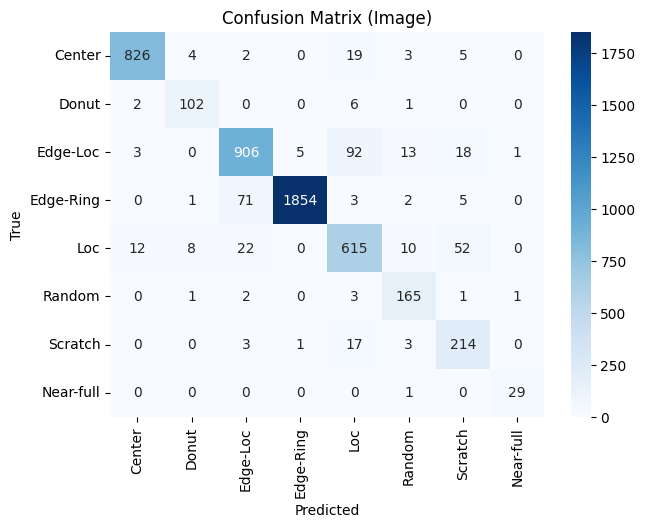

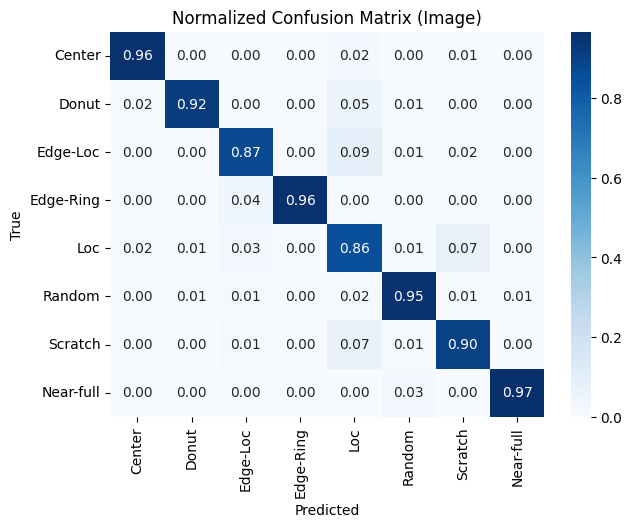

,Center,Donut,Edge-Loc,Edge-Ring,Loc,Random,Scratch,Near-full
Center,826,4,2,0,19,3,5,0
Donut,2,102,0,0,6,1,0,0
Edge-Loc,3,0,906,5,92,13,18,1
Edge-Ring,0,1,71,1854,3,2,5,0
Loc,12,8,22,0,615,10,52,0
Random,0,1,2,0,3,165,1,1
Scratch,0,0,3,1,17,3,214,0
Near-full,0,0,0,0,0,1,0,29


,Center,Donut,Edge-Loc,Edge-Ring,Loc,Random,Scratch,Near-full
Center,0.961583,0.004657,0.002328,0.000000,0.022119,0.003492,0.005821,0.000000
Donut,0.018018,0.918919,0.000000,0.000000,0.054054,0.009009,0.000000,0.000000
Edge-Loc,0.002890,0.000000,0.872832,0.004817,0.088632,0.012524,0.017341,0.000963
Edge-Ring,0.000000,0.000517,0.036674,0.957645,0.001550,0.001033,0.002583,0.000000
Loc,0.016690,0.011127,0.030598,0.000000,0.855355,0.013908,0.072323,0.000000
Random,0.000000,0.005780,0.011561,0.000000,0.017341,0.953757,0.005780,0.005780
Scratch,0.000000,0.000000,0.012605,0.004202,0.071429,0.012605,0.899160,0.000000
Near-full,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.966667


In [ ]:
# 9️⃣ 9단계. 혼동 행렬 시각화 및 배열 출력
cm      = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]
class_names = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

plt.figure(figsize=(7,5))
sns.heatmap(cm,     annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Image)"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

plt.figure(figsize=(7,5))
sns.heatmap(cm_norm,annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix (Image)"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

display(pd.DataFrame(cm,     index=class_names, columns=class_names))
display(pd.DataFrame(cm_norm,index=class_names, columns=class_names))
